In this project, we will use an RNN architecture to build a Machine Translation model.

It will use as a corpus wikipedia dumps.

Either the source or the target will be English. We will, in our case, try English to French Translation.

In [ ]:
#imports
!pip3 install numpy
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu117
#or any nightly version so long as pytorch > 1.11 https://pytorch.org/
!pip3 install gensim transformers d2l==1.0.0a1.post0

#In pytorch functional.py, change PILLOW_VERSION to __version__
#there are two places to change

Dataset

In [155]:
#Test samples location and preprocessing

#cell almost entirely from https://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html
import os
import torch
from d2l import torch as d2l

class MTFraEng(d2l.DataModule):  #@save
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

@d2l.add_to_class(MTFraEng)  #@save
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

@d2l.add_to_class(MTFraEng)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])  # src.append(EOS_token) ? 
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

@d2l.add_to_class(MTFraEng)  #@save
def __init__(self, batch_size, num_steps=15, num_train=162000, num_test=4000):  #15, 162000
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())


@d2l.add_to_class(MTFraEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train - self.num_test) if train else slice(self.num_train - self.num_test, self.num_train)
    return self.get_tensorloader(self.arrays, train, idx)

@d2l.add_to_class(MTFraEng)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

#src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
#print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
#print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

@d2l.add_to_class(MTFraEng)  #@save
def shuffle(self, train, seed, maxi):
    if (maxi > self.num_train):
        raise ValueError("maxi must be less than the length of the dataset")
    
    idx = torch.randperm(generator=torch.Generator().manual_seed(seed), n=maxi)
    if (not train):
        idx = idx[int(maxi * 0.7):]
    else :
        idx = idx[:int(maxi * 0.7)]
    return self.get_tensorloader(self.arrays, train, idx)
    

Word embedding

# We will use three different types of word embeddings:
# 1. Word2Vec
# 2. GloVe
# 3. FastText


In [2]:
"""## Word2Vec"""
import gensim

In [3]:
#keep in mind you have to launch the notebook inside the git folder to make this work (second one)
from inspect import getsourcefile
import sys
print(os.path.dirname(getsourcefile(lambda:0)))
print(sys.path[0])
print(os.path.abspath(sys.argv[0]))

C:\Users\gille\AppData\Local\Temp\ipykernel_17028
c:\Users\gille\OneDrive\Desktop\web\webtextanalysis
c:\Users\gille\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py


In [89]:
data = MTFraEng(batch_size=16)

In [90]:
src, tgt, src_valid_len, label = next(iter(data.shuffle(train=False, seed=0, maxi=1)))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))

source: tensor([[3681,   72,  187,  188,  188,  188,  188,  188,  188,  188,  188,  188,
          188,  188,  188]], dtype=torch.int32)
decoder input: tensor([[  136, 15923,     0,   137,   138,   138,   138,   138,   138,   138,
           138,   138,   138,   138,   138]], dtype=torch.int32)


In [91]:
import numpy as np

def save_split():
    data = MTFraEng(batch_size=5)
    with open("samples/source.txt", "w") as f:
        for i in range(0, data.num_train):
            for word in data.arrays[0][i].numpy() :
                f.write(str(word) + " ")
            f.write("\n")
            
    with open("samples/target.txt", "w") as f:
        for i in range(0, data.num_train):
            for word in data.arrays[1][i].numpy() :
                f.write(str(word) + " ")
            f.write("\n")
            
def load_source():
    return np.loadtxt("samples/source.txt", dtype=str)

def load_target():
    return np.loadtxt("samples/target.txt", dtype=str)

def word_to_token(word, src=True):
    if src :
        return data.src_vocab[word]
    else :
        return data.tgt_vocab[word]

def token_to_word(token, src=True):
    if src :
        return data.src_vocab.to_tokens(token)
    else :
        return data.tgt_vocab.to_tokens(token)

def test_similarity(model, word1, word2, model_name, src=True):
    print("Cosine similarity between '" + word1 + "' and '"+ word2 +"' - " + model_name + " : " + str(model.similarity(word_to_token(word1, src), word_to_token(word2, src))))


In [92]:
#print a few samples
for i in range(5):
    print(token_to_word(data.arrays[0][i].numpy(), True))

for i in range(5):
    print(token_to_word(data.arrays[1][i].numpy(), False))

['go', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['run', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['run', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['who', '?', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'va', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'salut', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'cours', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

In [130]:
if not os.path.exists(sys.path[0] + "/samples/source.txt") or not os.path.exists(sys.path[0] + "/samples/target.txt"):
    save_split()

In [93]:

source_text = load_source()
one_line_source = source_text.reshape([np.prod(source_text.shape)])

#format to be accepted by Word2Vec
one_line_source = [str(i).split() for i in one_line_source]

print(one_line_source[:4])
#print in words 
print([token_to_word(int(i[0]), src=True) for i in one_line_source[:4]])



target_text = load_target()
one_line_target = target_text.reshape([np.prod(target_text.shape)])

#format to be accepted by Word2Vec
one_line_target = [str(i).split() for i in one_line_target]

print(one_line_target[:4])
#print in words 
print([token_to_word(int(i[0]), src=False) for i in one_line_target[:4]])

[['3681'], ['72'], ['187'], ['188']]
['go', '.', '<eos>', '<pad>']
[['136'], ['15923'], ['0'], ['137']]
['<bos>', 'va', '!', '<eos>']


In [96]:
"""## Word2Vec"""

print(one_line_source[:5])

if not os.path.exists(sys.path[0] + "/models/source_w2v_cbow.txt"):
    # Create CBOW model
    source_w2v_model_cbow = gensim.models.Word2Vec(one_line_source, min_count = 2,
                                vector_size = 100, window = 5).wv

if not os.path.exists(sys.path[0] + "/models/source_w2v_skip.txt"):
    # Create Skip Gram model
    source_w2v_model_skip = gensim.models.Word2Vec(one_line_source, min_count = 2, vector_size = 100,
                                                window = 5, sg = 1).wv
    
if not os.path.exists(sys.path[0] + "/models/target_w2v_cbow.txt"):
    # Create CBOW model
    target_w2v_model_cbow = gensim.models.Word2Vec(one_line_target, min_count = 2,
                                vector_size = 100, window = 5).wv

if not os.path.exists(sys.path[0] + "/models/target_w2v_skip.txt"):
    # Create Skip Gram model
    target_w2v_model_skip = gensim.models.Word2Vec(one_line_target, min_count = 2, vector_size = 100,
                                                window = 5, sg = 1).wv

[['3681'], ['72'], ['187'], ['188'], ['188']]


In [97]:
#save the models
if not os.path.exists(sys.path[0] + "/models/source_w2v_cbow.txt"):
    source_w2v_model_cbow.save_word2vec_format(sys.path[0] + "/models/source_w2v_cbow.txt", binary=False)
    
if not os.path.exists(sys.path[0] + "/models/source_w2v_skip.txt"):
    source_w2v_model_skip.save_word2vec_format(sys.path[0] + "/models/source_w2v_skip.txt", binary=False)
    
if not os.path.exists(sys.path[0] + "/models/target_w2v_cbow.txt"):
    target_w2v_model_cbow.save_word2vec_format(sys.path[0] + "/models/target_w2v_cbow.txt", binary=False)

if not os.path.exists(sys.path[0] + "/models/target_w2v_skip.txt"):
    target_w2v_model_skip.save_word2vec_format(sys.path[0] + "/models/target_w2v_skip.txt", binary=False)

In [98]:
#load the models
source_w2v_model_cbow = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_w2v_cbow.txt", binary=False)
source_w2v_model_skip = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_w2v_skip.txt", binary=False)
target_w2v_model_cbow = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_w2v_cbow.txt", binary=False)
target_w2v_model_skip = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_w2v_skip.txt", binary=False)

In [99]:
test_similarity(source_w2v_model_cbow, 'hi', '.', "CBOW")
test_similarity(source_w2v_model_cbow, 'hi', 'run', "CBOW")

test_similarity(source_w2v_model_skip, 'hi', '.', "SkipGram")
test_similarity(source_w2v_model_skip, 'hi', 'run', "SkipGram")

test_similarity(target_w2v_model_cbow, 'bonjour', '.', "CBOW")
test_similarity(target_w2v_model_cbow, 'bonjour', 'cours', "CBOW")

test_similarity(target_w2v_model_skip, 'bonjour', '.', "CBOW")
test_similarity(target_w2v_model_skip, 'bonjour', 'cours', "CBOW")

Cosine similarity between 'hi' and '.' - CBOW : -0.03504046
Cosine similarity between 'hi' and 'run' - CBOW : -0.0359637
Cosine similarity between 'hi' and '.' - SkipGram : -0.03504046
Cosine similarity between 'hi' and 'run' - SkipGram : -0.0359637
Cosine similarity between 'bonjour' and '.' - CBOW : 0.24336207
Cosine similarity between 'bonjour' and 'cours' - CBOW : 1.0
Cosine similarity between 'bonjour' and '.' - CBOW : 0.24336207
Cosine similarity between 'bonjour' and 'cours' - CBOW : 1.0


In [100]:
"""## GloVe"""

# coding: utf-8
from gensim.models import KeyedVectors

In [ ]:
#once we have the tokenized file, we can call the glove model

####CALL FROM BASH glove_run.py

In [117]:
#Only do this once
source_file = sys.path[0] + '\\models\\source_glove.txt'
target_file = sys.path[0] + '\\models\\target_glove.txt'
# Load the model, can take a bit of time
source_glove_model = KeyedVectors.load_word2vec_format(source_file, binary=False, no_header=True)
target_glove_model = KeyedVectors.load_word2vec_format(source_file, binary=False, no_header=True)

In [118]:

# Test the model
test_similarity(source_glove_model, 'hi', '.', "GloVe", src=True)
test_similarity(source_glove_model, 'hi', 'run', "GloVe", src=True)

test_similarity(target_glove_model, 'bonjour', '.', "GloVe", src=False)
test_similarity(target_glove_model, 'bonjour', 'cours', "GloVe", src=False)

Cosine similarity between 'hi' and '.' - GloVe : -0.06486927
Cosine similarity between 'hi' and 'run' - GloVe : 0.15275551
Cosine similarity between 'bonjour' and '.' - GloVe : -0.03058168
Cosine similarity between 'bonjour' and 'cours' - GloVe : 0.5341698


#FastText

In [119]:
"""## FastText"""
from gensim.models import FastText

#if not saved yet we train it
if not os.path.exists(sys.path[0] + "/models/source_fast.txt"):
    source_fast_model = FastText(vector_size=100, window=5, min_count=2)
    source_fast_model.build_vocab(corpus_file=sys.path[0] + '/samples/source.txt')
    source_fast_model.train(corpus_file=sys.path[0] + '/samples/source.txt', epochs=10, total_examples=source_fast_model.corpus_count, total_words=source_fast_model.corpus_total_words)
    source_fast_model = source_fast_model.wv


In [120]:
if not os.path.exists(sys.path[0] + "/models/target_fast.txt"):
    target_fast_model = FastText(vector_size=100, window=5, min_count=2)
    target_fast_model.build_vocab(corpus_file=sys.path[0] + '/samples/target.txt')
    target_fast_model.train(corpus_file=sys.path[0] + '/samples/target.txt', epochs=10, total_examples=target_fast_model.corpus_count, total_words=target_fast_model.corpus_total_words)
    target_fast_model = target_fast_model.wv

In [121]:
if not os.path.exists(sys.path[0] + "/models/source_fast.txt"):
    source_fast_model.save_word2vec_format(sys.path[0] + "/models/source_fast.txt", binary=False)
if not os.path.exists(sys.path[0] + "/models/target_fast.txt"):
    target_fast_model.save_word2vec_format(sys.path[0] + "/models/target_fast.txt", binary=False)

In [26]:
#if saved we load it
source_fast_model = KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_fast.txt", binary=False)
target_fast_model = KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_fast.txt", binary=False)

In [122]:
test_similarity(source_fast_model,'hi', '.', "FastText", src=True)
test_similarity(source_fast_model,'hi', 'run', "FastText", src=True)

test_similarity(target_fast_model,'bonjour', '.', "FastText", src=False)
test_similarity(target_fast_model,'bonjour', 'cours', "FastText", src=False)

Cosine similarity between 'hi' and '.' - FastText : 0.007419374
Cosine similarity between 'hi' and 'run' - FastText : 0.4659179
Cosine similarity between 'bonjour' and '.' - FastText : 0.0039373655
Cosine similarity between 'bonjour' and 'cours' - FastText : 0.48374334


RNN

In [256]:
# Now we can create the RNN model that will translate from english to french using one of the previous embeddings

from torch import nn
import torch.nn.functional as F

class RNN(nn.Sequential):
    def __init__(self, embedding_model_input, embedding_model_output):
        super(RNN, self).__init__()

        self.embedding_in = embedding_model_input
        self.embedding_out = embedding_model_output

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.embedding_dim_in = self.embedding_in.vector_size
        self.lstm_in = nn.LSTM(self.embedding_dim_in, self.embedding_dim_in, bidirectional=True)
        self.hidden_in = nn.Linear(self.embedding_dim_in * 2, self.embedding_dim_in)
        
        self.embedding_dim_out = self.embedding_out.vector_size
        self.lstm_out = nn.LSTM(self.embedding_dim_in, self.embedding_dim_out, bidirectional=True)
        self.hidden_out = nn.Linear(self.embedding_dim_out * 2, self.embedding_dim_out)
        
        self.embedder = torch.tensor(self.embedding_out.vectors, requires_grad=True).to("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, input_sentence):
        #words_embeddings is a gensim model
        embeds = torch.tensor(np.array([[self.embedding_in[word.item()] if word.item() in self.embedding_in else self.embedding_in.vectors.mean(axis=0) for word in sentence] for sentence in input_sentence]), requires_grad=True).to("cuda" if torch.cuda.is_available() else "cpu")
        
        #encoder
        output_lstm_1, _ = self.lstm_in(embeds.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in))
        output_hidden_1 = self.hidden_in(output_lstm_1.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in * 2))
        soft = F.log_softmax(output_hidden_1, dim=2)
        
        #decoder
        output_lstm_2, _ = self.lstm_out(soft.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in))
        output_hidden_2 = self.hidden_out(output_lstm_2.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_out * 2))
        
        output_all = torch.matmul(output_hidden_2, self.embedder.transpose(0,1))

        return torch.argmax(output_all, dim=2)

In [228]:
#From this model we can create a loss function and an optimizer

def loss_function(predicted_sentence, target_sentence, embedding_model):
    
    #embedding_model.similarity(str(predicted_sentence[i][j].item()), str(target_sentence[i][j].item())
    return torch.tensor([1 - embedding_model.similarity(predicted_sentence[i][j].item(), target_sentence[i][j].item()) if predicted_sentence[i][j].item() in embedding_model and target_sentence[i][j].item() in embedding_model else 0 for i in range(predicted_sentence.shape[0]) for j in range(predicted_sentence.shape[1])], requires_grad=True).to("cuda" if torch.cuda.is_available() else "cpu").mean()


In [157]:
batch_size = 16

data = MTFraEng(batch_size=batch_size)

In [158]:
usage_size = 50000

print(len(data.get_dataloader(train=False)))
print(len(data.get_dataloader(train=True)))
print(len(data.shuffle(train=True, seed=0, maxi=usage_size)))
print(len(data.shuffle(train=False, seed=0, maxi=usage_size)))

250
9875
2188
938


In [257]:
#Now we can train the model
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNN(embedding_model_input=source_fast_model, embedding_model_output=target_fast_model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epoch = 10

size_per_epoch = int(usage_size * 0.7 / batch_size) + 1

def train() :
    epoch_loss = np.zeros(n_epoch)
    for epoch in range(n_epoch):
        counter = 0
        time_avg = 0
        for src, tgt, src_valid_len, label in data.shuffle(train=True, seed=0, maxi=usage_size):
            time_start = time.time()
            
            sentence = src.to(device)
            tags = label.to(device)
            
            optimizer.zero_grad()

            tag_scores = model(sentence)

            loss = loss_function(tag_scores, tags, target_fast_model)
            loss.retain_grad()
            
            loss.backward()
            
            print(loss.grad)
            print(model.hidden_out.weight.grad) #should't be None
            
            optimizer.step()

            counter += 1
            time_avg = time_avg * 0.95 + (time.time() - time_start) * (size_per_epoch - counter) * 0.01
            print("New step : ", counter, "/", size_per_epoch, " loss : ", loss.item(), " estimated time :", time_avg , end="\r")
            
        #here we can use the test data to evaluate the model
        with torch.no_grad() :
            losses = torch.zeros(int(usage_size * 0.3 / batch_size) + 1)
            counter = 0
            for src, tgt, src_valid_len, label in data.shuffle(train=False, seed=0, maxi=usage_size):
                sentence = src.to(device)
                tags = label.to(device)

                tag_scores = model(sentence)

                loss = loss_function(tag_scores, tags, target_fast_model)
                
                losses[counter] = loss.item()
                counter += 1

            epoch_loss[epoch] = losses.mean()
            print("Epoch: {}/{}.............".format(epoch, n_epoch), end=" ")
            print("Loss: " + str(epoch_loss[epoch]))
            
train()
    

RuntimeError: you can only change requires_grad flags of leaf variables.

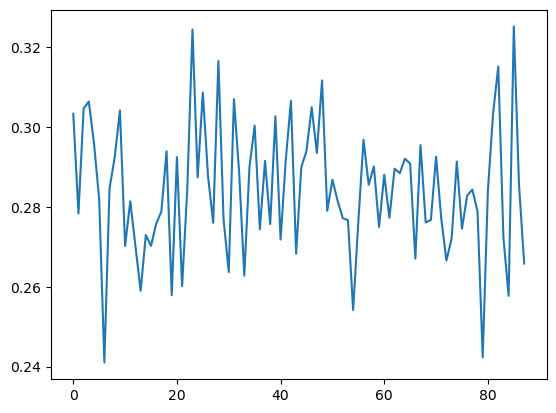

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss)

In [252]:
#sample a sentence from the test set
src, tgt, src_valid_len, label = next(iter(data.shuffle(train=False, seed=0, maxi=usage_size)))

#translate the sentence

sentence = src.to(device)
tags = tgt.to(device)

tag_scores = model(sentence)

loss = loss_function(tag_scores, tags, target_fast_model)

print("Loss : ", loss.item())

#print the original sentence
print("Original sentence : ")
for word in src[0]:
    print(token_to_word(word.item(), src=True), end=" ")
print()
for word in src[0]:
    print(word.item(), end=" ")
print()

#print the translated sentence
print("Translated sentence : ")
for word in tag_scores[0]:
    print(token_to_word(word.item(), src=False), end=" ")
print()
for word in tag_scores[0]:
    print(word.item(), end=" ")
print()

#print the target sentence
print("Target sentence : ")
for word in tgt[0]:
    print(token_to_word(word.item(), src=False), end=" ")
print()
for word in tgt[0]:
    print(word.item(), end=" ")
print()

for word in label[0]:
    print(token_to_word(word.item(), src=False), end=" ")
print()
for word in label[0]:
    print(word.item(), end=" ")
print()

Loss :  0.5495362701127305
Original sentence : 
i wish i was kidding . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
4228 9292 4228 9106 4665 72 187 188 188 188 188 188 188 188 188 
Translated sentence : 
: : : : : : : : : : : : : : : 
134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 
Target sentence : 
<bos> j'aimerais avoir <unk> . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
136 7559 1346 139 27 137 138 138 138 138 138 138 138 138 138 
j'aimerais avoir <unk> . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
7559 1346 139 27 137 138 138 138 138 138 138 138 138 138 138 


To this model we can now try to add contextual embeddings

In [ ]:
#for contextual embedding we will use BERT

import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

#we use bert and we will train it on the data
bert_model = BertModel.from_pretrained('bert-base-uncased')
#we will use the tokenizer to tokenize the sentences
sentences = ["I love machine learning", "I love coding in python"]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]